In [74]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

In [390]:
class LIF():
    def __init__(self, dt=0.1, v_decay=10, vt_decay=100, spike_weight=0.5, v_thresh = 1, v_weight=0.1, reset=0):
        self.dt = torch.tensor(dt, dtype=torch.float)
        self.v_decay = torch.tensor(v_decay, dtype=torch.float)
        self.vt_decay = torch.tensor(vt_decay, dtype=torch.float)
        self.spike_weight = torch.tensor(spike_weight, dtype=torch.float)
        self.v_thresh = torch.tensor(v_thresh, dtype=torch.float)
        self.v_weight = torch.tensor(v_weight, dtype=torch.float)
        self.reset = torch.tensor(reset, dtype=torch.float)
        
        self.v = reset
        self.v_hist = torch.zeros((0, 2), dtype=torch.float)
        
        self.vt = v_thresh
        self.vt_hist = torch.ones((0,2), dtype=torch.float) * self.vt
        
        self.v_exp = torch.exp(-self.dt/self.v_decay)
        self.vt_exp = torch.exp(-self.dt/self.vt_decay)
        
        self.spikes = torch.tensor(0, dtype=torch.float)
        self.timer = torch.tensor(0, dtype=torch.float)
        
        self.parameters = [self.v_decay, self.vt_decay, self.spike_weight, self.v_thresh, self.v_weight, self.reset]
        
    def step(self, spikes):
        self.timer += self.dt
        
        v_before = self.v
        vt_before = self.vt
        
        # decay V
        self.v = self.v * self.v_exp
        
        # decay V_t
        self.vt = (self.vt - self.v_thresh) * self.vt_exp + self.v_thresh
        
        # incoming incidents
        for _ in range(spikes):
            self.v += self.spike_weight
            
        # check threshold
        if(self.v >= self.vt):
            self.spikes += 1
            self.v = self.reset
            self.vt += self.v_weight
            
        v_after = self.v
        vt_after = self.vt
        
        self.v_hist = torch.cat([self.v_hist, torch.tensor([[v_before, v_after]])], dim=0)
        self.vt_hist = torch.cat([self.vt_hist, torch.tensor([[vt_before, vt_after]])], dim=0)
        
        return

In [391]:
def build_input_signal(duration, dt, ipd_deg=200, freq=5):
    xs = ((2*torch.pi)/1000) * torch.arange(0, duration, dt, dtype=torch.float) * freq
    return [xs.sin(), (xs + (ipd_deg*torch.pi)/180).sin()]

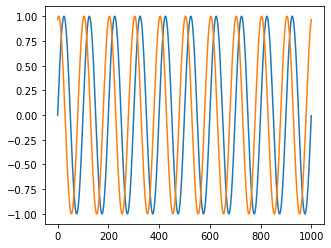

In [394]:
# all in ms
dt = 0.1
duration = 1000
times = torch.arange(0, duration, dt)
freq = 10
ipd_deg = 75

[signal0, signal1] = build_input_signal(duration, dt, ipd_deg, freq)

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(times, signal0)
plt.plot(times, signal1)

In [401]:
def simulate_ear_spikes(signal, rate_max_ms, dt):
    rates_thresh = dt * rate_max_ms*0.5*(1+signal)
    rands = torch.rand(rates_thresh.shape)
    
    return torch.where(rands < rates_thresh, 1, 0).float()
    

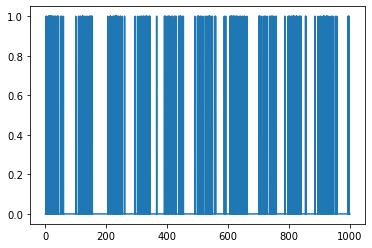

In [402]:
rate_max_second = 400
rate_max_ms = rate_max_second / 1000
spikes0 = simulate_ear_spikes(signal0, rate_max_ms, dt)
spikes1 = simulate_ear_spikes(signal1, rate_max_ms, dt)
plt.plot(times, spikes0)

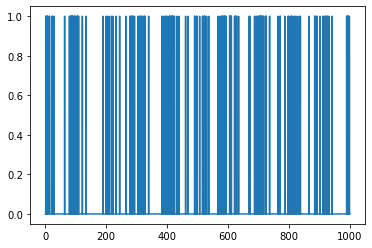

In [403]:
plt.plot(times, spikes1)

In [405]:
class CoincidenceDetector():
    def __init__(self, N_neurons, freq):
        delays0 = torch.arange(0, 1/freq, 1/(freq*N_neurons))*1000 # delays in ms
        delays1 = delays0.flip(dims=[0])
        self.delays = torch.stack([delays0, delays1]).T.int()
        self.max_delay = self.delays.max().int().item()
        self.freq = freq
        self.neurons = [LIF(
            dt=0.1,
            v_decay=1,
            vt_decay=4,
            spike_weight=0.6,
            v_thresh = 1,
            v_weight=0.1,
            reset=0
        ) for _ in range(N_neurons)]
        self.best_ipds = 360*torch.arange(0, N_neurons, dtype=torch.float)/(N_neurons-1)
        
        self.parameters = []
        for n in self.neurons:
            self.parameters += n.parameters
        
    def forward(self, signal0, signal1):
        for (neuron, [delay0, delay1]) in tqdm(zip(self.neurons, self.delays)):
            padded_signal0 = torch.zeros(self.max_delay + signal0.shape[0])
            padded_signal0[delay0: delay0 + signal0.shape[0]] = signal0
            
            padded_signal1 = torch.zeros(self.max_delay + signal1.shape[0])
            padded_signal1[delay1: delay1 + signal1.shape[0]] = signal1
            
            signal = (padded_signal0 + padded_signal1).int()
            
            for t in range(len(signal)):
                neuron.step(signal[t])
                
        return torch.tensor([n.spikes for n in self.neurons])


In [406]:
cd = CoincidenceDetector(10, freq)

In [407]:
res = cd.forward(spikes0, spikes1)

10it [00:03,  2.94it/s]


In [ ]:
## plt.figure(figsize=(6, 4), dpi=100)
plt.scatter(cd.best_ipds, res, s=3, c='k')
plt.axvline(ipd_deg, ls='--', c='b', label='True IPD')
plt.axvline(ipd_est, ls='--', c='r', label='Estimated IPD')
plt.xlabel('IPD (deg)')
plt.ylabel('Spike count')
plt.legend(loc='lower right')
plt.tight_layout()

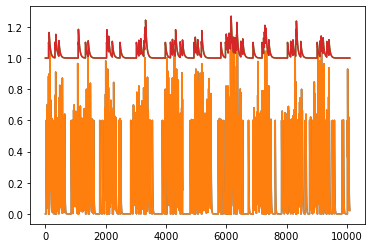

In [307]:
n = 5
v = cd.neurons[n].v_hist
vt = cd.neurons[n].vt_hist

plt.plot(range(len(v)), v)
plt.plot(range(len(v)), vt)

In [308]:
freq = 5
rate_max_second = 200
rate_max_ms = rate_max_second / 1000

preds = []

for ipd in torch.arange(0, 360, 36):
    
    [signal0, signal1] = build_input_signal(duration, dt, ipd, freq)
    
    spikes0 = simulate_ear_spikes(signal0, rate_max_ms, dt)
    spikes1 = simulate_ear_spikes(signal1, rate_max_ms, dt)
    
    cd = CoincidenceDetector(100, freq)
    
    cd.forward(spikes0, spikes1)
    
    m = cd.spike_counts.max()
    ipd_est = cd.best_ipds[(cd.spike_counts == m).nonzero().squeeze()].mean().item()
    preds += [ipd_est]

16it [00:06,  2.55it/s]


KeyboardInterrupt: 

In [388]:
# Mean error should be calculated in a circular fashion
# Giving 359 degrees when the answer is 0 is 1 degree not 359
# So compute +-360 deg and take the minimum

def plot_results(ipds, ipds_est):
    abs_errors_deg = abs(ipds - ipds_est)
    plt.figure(figsize=(8, 4), dpi=100)
    plt.subplot(121)
    plt.plot(ipds, ipds_est, '.k')
    plt.plot([0, 360], [0, 360], '--g')
    plt.xlabel('True IPD (deg)')
    plt.ylabel('Estimated IPD (deg)')
    plt.subplot(122)
    plt.plot(ipds, abs_errors_deg, '.k')
    mean_abs_error_deg = abs_errors_deg.mean()
    plt.axhline(mean_abs_error_deg, ls='--', c='b', label=f'Mean error = {int(mean_abs_error_deg)}')
    plt.xlabel('True IPD (deg)')
    plt.ylabel('Absolute error (deg)')
    plt.legend(loc='best')
    plt.tight_layout();
    
plot_results(torch.arange(0, 360, 36), torch.tensor(preds))

RuntimeError: The size of tensor a (10) must match the size of tensor b (0) at non-singleton dimension 0